# Project: Sentiment Analysis

**Author: Kun Jiang (kunjiang0112@gmail.com)**

This project addresses the problem of sentiment analysis in IMDB movie reviews by classifying movie comments according to the sentiment expressed in them: "positive" or "negative". The purpose of this project is to describe the process to develop a automatic classifier using machine learning and deep learning algorithms for accurate sentiment classification of an unknown IMDB movie comment. 

In this notebook, I use different packages in Python to build a complete pipeline for solving sentiment analysis problem

**Outline:**

- Load Dataset

- Feature Extraction
    * Count Vectorizer
    * Tf-idf

- Classification Models
    * Naive Bayes 
    * Supported Vector Machine(SVM)
    * Tf-idf + Logistic Regression
    * Deep Learning (CNN & LSTM)
    
    
Make sure the following enviroment and packages are installed:

- anaconda3 w/ python 3.6
- scikit-learn
- tensorflow
- keras
- nltk
- pandas, numpy, matplotlib



# Load Dataset

The Movie Review Data is a collection of movie reviews retrieved from the imdb.com website. You can download the dataset from here:

Large Movie Review Dataset http://ai.stanford.edu/~amaas/data/sentiment/

The dataset provides a set of 25,000 highly polar movie reviews for training (train.csv), and 25,000 for testing (test.csv). Raw text and already processed bag of words formats are provided.

Next, let’s look at loading and preparing the text data.

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

In [2]:
# Load csv file into DataFrame
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print("sentiment  :", train.sentiment[0])
print("reviewText :", train.reviewText[0])

sentiment  : pos
reviewText : For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


In [4]:
train.shape

(25000, 2)

In [5]:
# Get a sample (head) of the data frame
train.head()

,reviewText,sentiment
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [6]:
# Statics on tags
train.sentiment.value_counts()


neg    12500
pos    12500
Name: sentiment, dtype: int64

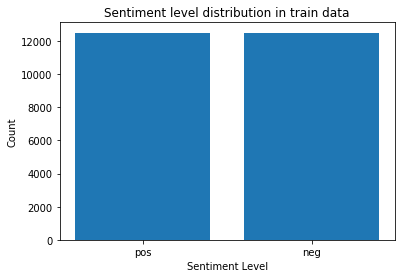

In [7]:
plt.bar(train.sentiment.unique(), train.sentiment.value_counts())
plt.xlabel('Sentiment Level')
plt.ylabel('Count')
plt.title('Sentiment level distribution in train data')
plt.show()

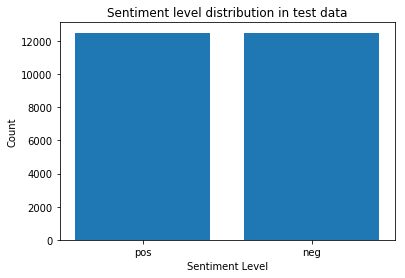

In [8]:
plt.bar(test.sentiment.unique(), test.sentiment.value_counts())
plt.xlabel('Sentiment Level')
plt.ylabel('Count')
plt.title('Sentiment level distribution in test data')
plt.show()

### Load Data in to List

Loading dataset into list helps the processsing of movie reivews

In [9]:
def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y

In [10]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')

In [11]:
print('training size:', len(train_x))
print('test size:', len(test_x))

training size: 25000
test size: 25000


### Preprocessing

Cleaning the document involves splitting each review based on white space, removing punctuation, and then filtering out all tokens not in the vocabulary.

- Just looking at the raw tokens can give us a lot of ideas of things to try, such as:
    * Lematize tokens (e.g. 'drive, drove, drived' --> 'driv')
    * Remove punctuation from words (e.g. ‘what’s’,  ‘-‘). We can filter out punctuation from tokens using the string translate() function.
    * Removing tokens that are just stop words and don't have much meanings (e.g. 'I', 'you', 'me', ‘and’). We can remove stop words using the list loaded using NLTK.
    * Removing tokens that are numbers (e.g. ’10′).
    * Remove tokens that don’t have much meaning (e.g.)

In [12]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [13]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# preprocessing() function treat a line of comment by removing html tag, converting to lower case, 
# splitting each review based on white space, removing punctuation
def preprocessing(line):
    line = line.replace('<br />', '')   # Remove html tag (<br />)
    line = line.translate(transtbl)     # Remove punctuation
    
    # Get tokens
    tokens = []
    for t in nltk.word_tokenize(line):
        t = t.lower()
        if t not in stopwords:
            lemma = lemmatizer.lemmatize(t, 'v')
            tokens.append(lemma)
            
    return ' '.join(tokens)

In [16]:
test_str = "I bought several books yesterday<br /> and I really love them!"
preprocessing(test_str)

'buy several book yesterday really love'

In [17]:
# Preprocess both train and test data 
train_x = [preprocessing(x) for x in train_x]
test_x = [preprocessing(x) for x in test_x]

### Build Vocabulary

Before running the model, it is important to build a vocabulary of known words when using a bag-of-words or embedding model. We can develop a vocabulary as a Counter, which is a dictionary mapping of words and their counts that allow us to easily update and query. The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive.

nltk provides a simple function to build a covabulary called FreqDist(), which will be used in this part. Each review can be added to the counter and we can step over all of the reviews in the train and test data. 

In [18]:
# Push all tokens and compute frequency of words
all_words = []
for line in train_x:
    words = line.split()
    for w in words:
        all_words.append(w)
for line in test_x:
    words = line.split()
    for w in words:
        all_words.append(w)
        
voca = nltk.FreqDist(all_words)

In [19]:
len(voca)

91654

In [20]:
# preview the most common 10 words
voca.most_common(10)

[('film', 95792),
 ('movie', 87752),
 ('one', 53514),
 ('make', 46110),
 ('like', 44237),
 ('see', 41568),
 ('get', 35666),
 ('time', 31864),
 ('good', 29703),
 ('character', 28299)]

We can see that there are a little over 91,000 unique words across all reviews and the top 10 words are ‘film‘, 'movie', ‘one‘, 'make', 'like', 'see', 'get', 'time', 'good', 'character'.  

Generally, words that only appear once or a few times are probably not predictive and can be removed from the vocabulary, greatly cutting down on the tokens we need to model. We can remove the less-frequent words by selecting the top 10000 words. We can then save the chosen vocabulary of words to a new list called topwords

In [21]:
# select the top 10, 000 words
topwords = [fpair[0] for fpair in list(voca.most_common(10000))]

### Vectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
cnt_vec = CountVectorizer()
cnt_vec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
# Create our BAG of words (specify words we care about)
cnt_vec.fit(topwords)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Tf–idf 

- Tf: term-frequency
- idf: inverse document-frequency
- Tf-idf = $tf(t,d) \times idf(t)$

TF-IDF stands for Term frequency inverse document frequency, is a statistical measure to see how important the appearance of a word in a document corpus is for classification. Term frequency measures how many times a term has appeared in a particular document, and inverse document frequency measures logarithm inverse of number of ducuments that have that word out of total number of documents. Augmented TF-IDF is used to avoid bias towards longer documents, and it is defined as below for a term $t$ appearing in a particular document $d$:

$$ TF(t, d) = 0.5 + \frac{0.5 \times freq(t, d)}{max(freq(w, d) \ \ where\  w \in d)} $$$$IDF(t, D_{train}) = \frac{|D_{train}|}{|\{d\in D_{train} \ \ where\  t \in d\}|}$$
and

$$TFIDF(t, d, D) = TF(t,d) \times IDF(t, d)$$
where $D_{train}=\{set\ of\ all\ training\ documents\}$. It is important to note that TF-IDF depends on the entire set of documents that we are considering (for example the training set), and not just the term in a document


In [25]:
tf_vec = TfidfVectorizer()
tf_vec.fit(topwords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### Feature Extraction

In [26]:
# Extract features from training set
# Vocabulary is from topwords
tf_vec = TfidfVectorizer(vocabulary=topwords)
train_features = tf_vec.fit_transform(train_x)

In [27]:
train_features.shape

(25000, 10000)

In [28]:
test_features = tf_vec.transform(test_x)
test_features.shape

(25000, 10000)


## 1: Naive Bayes
Naive bayes is a popular algorithm for classifying text. Although it is fairly simple, it often performs as well as much more complicated solutions. We will start to build a Naive Bayes model, which will be used as a baseline in our prediction. 

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

We will be using Mutinomial Naive Bayes in this section.The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work

In [29]:
from sklearn.naive_bayes import MultinomialNB

In [30]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
# Train Model
import time

start = time.time()
mnb_model.fit(train_features, train_y)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.025601 seconds


In [32]:
# Predict
pred = mnb_model.predict(test_features)
print(pred)

['pos' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [33]:
# Metrics
# metrics.accuracy_score(y_true, y_pred)
from sklearn import metrics
accuracy = metrics.accuracy_score(pred,test_y)
print(accuracy)

0.83284


In [34]:
# Use keyword arguments to set arguments explicitly
print(metrics.classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.81      0.86      0.84     12500
        pos       0.86      0.80      0.83     12500

avg / total       0.83      0.83      0.83     25000



#### Select the best topwords number with Word Count and Tf-idf

since we have the basic model built with Naive Bayes, we can also optimize the number of topwords with the best performance

In [35]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [fpair[0] for fpair in list(voca.most_common(n))]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y), mnb_model, vec

In [36]:
possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for i, n in enumerate(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
   
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])
 

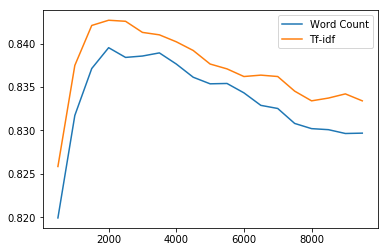

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()

#### Save best multinomial NB model (top_N = 3000)

From previous step it can be found that the number of topwords at 3000 words gives the best performing model. 
Here we can save the multinominal NB mode and the vocabulary at 3000 topwords for modeling in the later stage.


In [38]:
best = train_with_n_topwords(3000, tfidf=True) # best = (acc, model, vec)

In [39]:
topwords = [fpair[0] for fpair in list(voca.most_common(3000))]
tf_vec = TfidfVectorizer(vocabulary=topwords)
train_features = tf_vec.fit_transform(train_x)
test_features  = tf_vec.transform(test_x)

best_mnb_model = best[1]
pred = best_mnb_model.predict(test_features)
print(metrics.classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.84      0.85      0.84     12500
        pos       0.85      0.84      0.84     12500

avg / total       0.84      0.84      0.84     25000



After optimizing the size of the topwords, the NB model gives around 84% of accuracy using top 3000 words there is a slight improvement compared to the previous NB model (83%).

Next, we need to save the vectonizer and the model trained at 3000 topwords for later usage. 

In [40]:
import pickle

# Save vectorizer
with open('tf_vec.pkl', 'wb') as pkl_file:
    pickle.dump(best[2], pkl_file)

with open('mnb_model.pkl', 'wb') as pkl_file:
    pickle.dump(best[1], pkl_file)

In [41]:
sample = ["this movie is bad"]
sample_features  = tf_vec.fit_transform(sample)
sample_prediction = best_mnb_model.predict(sample_features)[0]
print ("the prediction result on the sample comment is: " + sample_prediction)


the prediction result on the sample comment is: neg


## 2. SVM
The Supported Vector Machine Classifier constructs a set of hyperplanes in a high dimensional space for classifications, trying to create a line that divides the dataset leaving the larger margin as possible between points called support vectors. In order to achieve a good classification, the distance from hyperplanes to the nearest training points should be maximized.

In [42]:
import pickle
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn import metrics

First we need to reload the td-idf vectornizer pretrained in the previous step. 

In [43]:
with open('tf_vec.pkl', 'rb') as fp:
    tf_vec = pickle.load(fp)

After that, we need to reload the data from csv files, process them with the preprocessing() function and transform the train and test features using the tf-idf vectornizer

In [44]:
# Load data
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')
# preprocess
train_x = [preprocessing(x) for x in train_x]
test_x = [preprocessing(x) for x in test_x]
# tf_idf transform
train_features = tf_vec.fit_transform(train_x)
test_features  = tf_vec.transform(test_x)

We then create our SVM classifier with the class LinearSVC and train it

In [45]:
import time

start = time.time()

svm_model = LinearSVC()
svm_model.fit(train_features, train_y)

end = time.time()

print("LinearSVC model trained in %f seconds" % (end-start))

LinearSVC model trained in 0.536604 seconds


#### SVM prediction

Make predictions on test data using the trained SVM model, generate the classification report and check the performance of the classifier. 

In [46]:
pred = svm_model.predict(test_features)

In [47]:
accuracy = metrics.accuracy_score(pred,test_y)
print(accuracy)

0.86528


In [48]:
print(metrics.classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.87      0.87      0.87     12500
        pos       0.87      0.87      0.87     12500

avg / total       0.87      0.87      0.87     25000



Computing the score took less than 1 second only! Running the classifier we get around 87% of accuracy, which is slightly better than the result of the naive bayes classifier. 

In [49]:
sample = ["this movie is not good"]
sample_features  = tf_vec.transform(sample)
sample_prediction = svm_model.predict(sample_features)[0]
print ("the prediction result on the sample comment is: " + sample_prediction)


the prediction result on the sample comment is: pos


### 3. Tf-idf + Logistic Regression

Additional to NB and SVM, Logistic regression is also a linear, powerful and widely used model for classifying binary outputs.Logistic regression is a sigmoid function to estimate probabilities between positive or negative label y and data features x.

In this section, we will start with train_features prepared in the SVM step and build a Logistic Regresssion model on it. 

In [50]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
import time

start = time.time()

lgr_model = LogisticRegression()
lgr_model.fit(train_features, train_y)

end = time.time()

print("Tf-idf + Logistic Regression model trained in %f seconds" % (end-start))

Tf-idf + Logistic Regression model trained in 0.436801 seconds


In [52]:
pred = lgr_model.predict(test_features)

In [53]:
accuracy = metrics.accuracy_score(pred,test_y)
print(accuracy)

0.87664


In [54]:
print(metrics.classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.88      0.87      0.88     12500
        pos       0.87      0.88      0.88     12500

avg / total       0.88      0.88      0.88     25000



In [55]:
sample = ["this movie is bad"]
sample_features  = tf_vec.transform(sample)
sample_prediction = lgr_model.predict(sample_features)[0]
print ("the prediction result on the sample comment is: " + sample_prediction)


the prediction result on the sample comment is: neg


It can be found that the Tf-idf + Logistic Regression model runs very fast (< 0.5 seconds), yet gives the best accurancy so far (88%). 

Although Naïve Bayes and Logistic regression are linear classifiers, Naïve Bayes is a generative classifier that tries
to predict the likelihood term under the assumption of conditionally independent between features, however, this assumption less happened in the real word problems, but in contrast, Logistic regression is a discriminative classifier that use a Logistic function to get the likelihood directly. In addition, Logistic regression covers the case of a binary dependent variable. As our dataset are going to be classified in a positive and negative labels, it is expected to have better performance than Naïve Bayes and SVM. 

### 4. Word Embedding with Neural Network model

Next, we will explore some of the advanced deep learning algorithms including Neural Networks and LSTM. 

This seciton will develop word embedding models for neural networks to classify movie reviews. it covers what is word embedding as part of fitting a deep learning model and how to use a pre-trained embedding in a neural network model.

In order to understand how deep learning can be applied, think about all the different forms of data that are used as inputs into machine learning or deep learning models. Instead of having a string input, we will need to convert each word in the comment in the sentence to a vector. The vector representation of a word is also known as a word embedding.

#### load pre-trained word vectors
In this part we will use pre-trained word embeddings, as opposed to having the system learn the word embeddings form our data. You can download pre-trained GloVe vectors from the [Stanford webpage](https://nlp.stanford.edu/projects/glove/). 

Unzipping the file, you will find pre-trained embeddings for various different dimensions. We will load the 50 dimension version in the file ‘glove.6B.50d.txt‘. 

Here, we’ll pass in words to an embedding layer. You can actually train up an embedding with word2vec and use it here. But it’s good enough to just have an embedding layer and let the network learn the embedding table on it’s own. 

In order to build the embedding layer, 2 dictionaries need to be loaded:

- `word_to_index`: dictionary mapping from words to their indices in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

The reason we need `word_to_index` is that when adding a custom embedding layer in Keras, we can only load the pretrained embedding as a matrix instead of a dictionary. A index will help us find the correct entry for a given word

In [56]:
def read_glove_vec(glove_file):
    with open(glove_file, 'r', encoding='utf-8', errors='ignore') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        for w in sorted(words):
            words_to_index[w] = i
            i = i + 1
    return words_to_index, word_to_vec_map

In [57]:
# load the 50 dimension version in the file ‘glove.6B.50d.txt‘
_, word_to_vec_map = read_glove_vec('data/glove.6B.50d.txt')

In [58]:
type(word_to_vec_map)

dict

Next, we need to load all of the training data movie reviews. For that, we can adapt the load_data() and preprocessing() from the previous section to load the csv documents, clean them, and return them as a list of strings. We want each document to be a string for easy encoding as a sequence of integers later.

In [59]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')
train_x = [preprocessing(x) for x in train_x]
test_x = [preprocessing(x) for x in test_x]

The next step is to encode each document as a sequence of integers.The Keras Embedding layer requires integer inputs where each integer maps to a single token that has a specific real-valued vector representation within the embedding. We can encode the training documents as sequences of integers using the Tokenizer class in the Keras API.

First, we must construct an instance of the class then train it on all documents in the training dataset. In this case, it develops a vocabulary of all tokens in the training dataset and develops a consistent mapping from words in the vocabulary to unique integers. We could just as easily develop this mapping ourselves using our vocabulary file.

In [60]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_x)

C:\Users\user\AppData\Local\conda\conda\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now that the mapping of words to integers has been prepared, we can use it to encode the reviews in both training and test dataset. We can do that by calling the texts_to_sequences() function on the Tokenizer. 

In [61]:
# sequence encode
train_x_ec = tokenizer.texts_to_sequences(train_x)
test_x_ec = tokenizer.texts_to_sequences(test_x)

After encoding the input features, we also need to encode the output value into binary for both train and test data: 
- binary encoding: 
    * pos --> 1
    * neg --> 0

In [62]:
train_y_ec = np.array([0 if x == 'neg' else 1 for x in train_y])
test_y_ec = np.array([0 if x == 'neg' else 1 for x in test_y])
print(train_y_ec)
print(test_y_ec)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


Next, We also need to ensure that all documents have the same length. This is a requirement of Keras for efficient computation. Since the reviews differ heavily in terms of lengths we need to have review samples to be the same length.  In this case, we will pad all reviews to 100. If reviews are shorter than the longest review,  we will pad them with zeros. 

In [63]:
from keras.preprocessing.sequence import pad_sequences

# max_length = max([len(s.split()) for s in train_x])
Xtrain = pad_sequences(train_x_ec, maxlen=100, padding='post')
Xtest = pad_sequences(test_x_ec, maxlen=100, padding='post')

In [64]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

We can now load the GloVe embedding and create the Embedding layer. The Glove file does not contain a header file, so we do not need to skip the first line when loading the embedding into memory. The updated load_embedding() function is listed below.

In [65]:

# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r',encoding='utf-8', errors='ignore')
	lines = file.readlines()
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

It is possible that the loaded embedding does not contain all of the words in our chosen vocabulary. As such, when creating the Embedding weight matrix, we need to skip words that do not have a corresponding vector in the loaded GloVe data. Below is the updated, more defensive version of the get_weight_matrix() function.

In [66]:
# from numpy import zeros

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = np.zeros((vocab_size, 50))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix

Note that the prepared weight matrix embedding_vectors is passed to the new Embedding layer as an argument and that we set the ‘trainable‘ argument to ‘False‘ to ensure that the network does not try to adapt the pre-learned vectors as part of training the network.

In [67]:
from keras.layers import Embedding
# load embedding from file
raw_embedding = load_embedding('data/glove.6B.50d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_vectors], input_length=100, trainable=False)

We can now add this layer to our model. We also have a lot more filters (128) in the CNN model and a kernel that matches the 5 words used as neighbors when developing the word2vec embedding. Finally, the back-end of the model was simplified.

- Steps of using Keras to build a neural network:
    * Define the structure of the network.
    * Print the summary of your network to see if shape and #of params is correct.
    * Compile the model.
    * Fit the model.
    * Evaluate the model.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

start = time.time()

# define model
cnn_model = Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))
print(cnn_model.summary())
# compile network
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
cnn_model.fit(Xtrain, train_y_ec, epochs=100, verbose=2)

end = time.time()
print("Neural Network model trained in %f seconds" % (end-start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3254100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6145      
Total params: 3,292,373
Trainable params: 38,273
Non-trainable params: 3,254,100
_________________________________________________________________
None
Epoch 1/100
 - 16s - loss: 0.5310 - acc: 0.7372
Epoch 2/100
 - 14s - loss: 0.4210 - acc: 0.8086
Epoch 3/100
 - 14s - loss:

In [ ]:
# evaluate
loss, acc = cnn_model.evaluate(Xtest, test_y_ec, verbose=2)
print('Test Accuracy: %f' % (acc))

In [ ]:
pred = cnn_model.predict(Xtest, verbose=2)
# covert pred into binary 
pred_test_y = [0 if y < 0.5 else 1 for y in pred]
print(metrics.classification_report(y_true=test_y_ec, y_pred=pred_test_y))

In [ ]:
sample = ["this movie is good"]
sample_ec = tokenizer.texts_to_sequences(sample)
sample_ec_pad = pad_sequences(sample_ec, maxlen=100, padding='post')
sample_prediction = cnn_model.predict(sample_ec_pad)
result = "neg" if sample_prediction < 0.5 else "pos"
print ("the prediction result on the sample comment is: " + result)

Running the example shows that performance was not improved.
In fact, performance was a lot worse. The results show that the training dataset was learned successfully, but evaluation on the test dataset was very poor, at just above 75% accuracy.

### 5. LSTM (Long Short Term Memory)
Long-Term Short Term Memory (LSTMs) are a type of network that has a memory that "remembers" previous data from the input and makes decisions based on that knowledge. These networks are more directly suited for written data inputs, since each word in a sentence has meaning based on the surrounding words (previous and upcoming words).

In our particular case, it is possible that an LSTM could allow us to capture changing sentiment in a comment. The LSTM can learn that sentiments expressed towards the end of a sentence mean more than those expressed at the start.

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from keras.preprocessing import sequence

np.random.seed(1)

In [ ]:
word_to_index, word_to_vec_map = read_glove_vec('data/glove.6B.50d.txt')

In [ ]:
from keras.preprocessing import sequence

In [ ]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_x)
# sequence encode
train_x_ec = tokenizer.texts_to_sequences(train_x)
test_x_ec = tokenizer.texts_to_sequences(test_x)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

Xtrain = pad_sequences(train_x_ec, maxlen=100, padding='post')
Xtest = pad_sequences(test_x_ec, maxlen=100, padding='post')

In [ ]:
from keras.layers import Embedding, SpatialDropout1D
# load embedding from file
raw_embedding = load_embedding('data/glove.6B.50d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_vectors], input_length=100, trainable=False)

Next we will build a LSTM model that receives the processed embedding_layer with vectorized words as input to generate prediction. Our model is composed of the embedding layer as input, a single LSTM layer, a dense layer with tanh activation followed by a logistic regression layer. 

In [ ]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(SpatialDropout1D(0.4))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(20, activation='tanh'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
end = time.time()
print("Neural Network model trained in %f seconds" % (end-start))print(model.summary())

In [ ]:
start = time.time()

history = lstm_model.fit(Xtrain, train_y_ec, batch_size=32, epochs = 300, verbose = 2)

end = time.time()
print("LSTM model trained in %f seconds" % (end-start))

In [ ]:
score,acc = lstm_model.evaluate(Xtest, test_y_ec, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
pred = lstm_model.predict(Xtest)
pred_test_y = [0 if y < 0.5 else 1 for y in pred]
print(metrics.classification_report(y_true=test_y_ec, y_pred=pred_test_y))

It can be found that the LSTM model provides 87% accurancy, much better than NB, SVM, and CNN but still 1% less than Tf-Idf LR model. 

In [ ]:
h = history.history.copy()

In [ ]:
plt.plot(h['acc'])

In [ ]:
plt.plot(h['loss'])

In [ ]:
sample = ["this movie is not good"]
sample_ec = tokenizer.texts_to_sequences(sample)
sample_ec_pad = pad_sequences(sample_ec, maxlen=100, padding='post')
sample_prediction = lstm_model.predict(sample_ec_pad)
result = "neg" if sample_prediction < 0.5 else "pos"
print ("the prediction result on the sample comment is: " + result)

Looking at the history curves above, it seems that the model's training is going well. The loss is decreasing steadily, and the accuracy is increasing gradually.


## Conclusion
In this notebook, we went over the entire process to build an automatic sentiment analysis using advanced machine learning and deep learning models including NB, SVM, Logistic Regression, Neural Network, LSTM. We introduced different components involved in the whole pipeline and have evaluated and compared our model performance.  

Comparing the different models built before, it can be found that the logistic regression gives the best accurancy with very fast training. The advanced deep learning algorithms (CNN and LSTM) doesn't provide better performance than linear models. One possible explanation for the poor performance might cause by the small size of the dataset (25K), where CNN and RNN should perform better with larger set of training data ( > millions).